In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [3]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [5]:
def show_table():
    q = ''''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ('table','view');
    ''''
    return run_query(q)
show_table()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Tracks sold by Genre

In [13]:
tracks_sold = '''
WITH tracks_sold_us AS
    (
     SELECT il.* from invoice_line il
     INNER JOIN invoice i on il.invoice_id = i.invoice_id
     INNER JOIN customer c on i.customer_id = c.customer_id
     WHERE c.country = "USA"
    )

SELECT 
    g.name genre,
    count(tsu.invoice_id) tracks_sold,
    cast(count(tsu.invoice_id) AS FLOAT) / (
        SELECT COUNT(*) from tracks_sold_us
        ) percentage_sold
    FROM tracks_sold_us tsu
    INNER JOIN track t on tsu.track_id = t.track_id
    INNER JOIN genre g on t.genre_id = g.genre_id
    GROUP BY 1
    ORDER BY 2 DESC;
    '''

run_query(tracks_sold)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


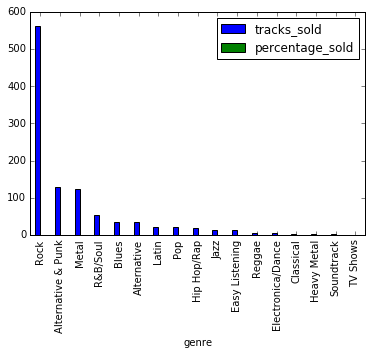

In [18]:
genre_sales_usa = run_query(tracks_sold)
genre_sales_usa.set_index("genre", inplace=True)

genre_sales_usa.plot.bar(
    xlim=(0, 600))

Based on the current sales by genre in the USA, only Red Tone Genre represente a total of sale above 10% we should find an Artist with an album from the Rock genre who represente 53% of total sales.

# Analyzing Sales Performance by Employee

In [20]:
employee_performance = '''
WITH employee_sales AS
    (
     SELECT
     i.customer_id,
     c.support_rep_id,
     SUM(i.total) total
     FROM invoice i
     INNER JOIN customer c on c.customer_id = i.customer_id
     GROUP BY 1,2
     )

SELECT
    e.first_name || " " || e.last_name employee,
    e.title,
    e.hire_date,
    SUM(es.total) total_sales
    FROM employee_sales es
    INNER JOIN employee e on e.employee_id = es.support_rep_id
    GROUP BY 1;
    '''
run_query(employee_performance)

,employee,title,hire_date,total_sales
0,Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,1731.51
1,Margaret Park,Sales Support Agent,2017-05-03 00:00:00,1584.00
2,Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,1393.92


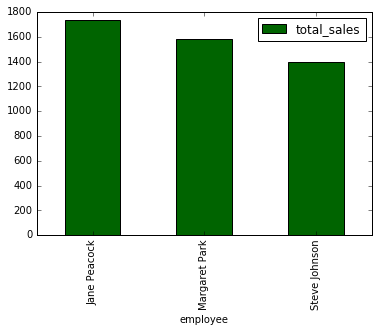

In [29]:
employee_perf = run_query(employee_performance)
employee_perf.set_index("employee", inplace=True)

employee_perf.plot.bar(
    xlim=(0, 1900),top enm
    color='DarkGreen'
    )

There is approximately 300 sales difference between the top and bottom employee, the difference can be correlated with the difference in their respective hiring dates.

# Sales By Country